<a href="https://colab.research.google.com/github/sangeetajay/Springboard/blob/master/7_AH_modeling_mixedinputs_RGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Capstone Project:
# Predicting House Prices from Zillow Images

## Pre-Processing/Modeling Notebook 7:

In this notebook, we will utilize both the image data and numerical and categorical features data in the neural network as previously, but this time we will try using color images (RGB) with the normalized price values.

Sections:
1. Imports
2. Prepare Image Data for CNN Model
3. Prepare Home Features Data for MLP model
4. Data Generator
5. Mixed Inputs Model Creation
6. Training the Model
7. Model Assessment



## 1. Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns 
%matplotlib inline

import PIL
import PIL.Image
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage.io import imread
from skimage.transform import resize
import math
from IPython.display import display
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Concatenate, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
# Import the EarlyStopping and ModelCheckpoint callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



tf.__version__

'2.6.0'

In [ ]:
#!pip install -q tensorflow==2.1
#!pip install -q keras==2.3.1
#!pip install -q tensorflow-estimator==2.1.
#!pip install gast==0.3.2
#!pip install tensorflow

## 2. Load the Image Data for CNN

#### 2a. Unzip image files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!unzip /content/drive/MyDrive/ResizedHomeImages.zip

#### 2b. Load training labels for the images




In [4]:
# load the cleaned dataset with image name and price
# these are the 'labels' for the images
file = '/content/drive/MyDrive/cleaned_AH_data_v2.csv'
train_labels = pd.read_csv(file)
# remove the .jpg from the image names
train_labels['Image Name'] = train_labels['Image Name'].str.rstrip('.jpg')
#check the shape
print(train_labels.shape)

train_labels.head()

(15012, 2)


,Image Name,Price
0,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f,305000
1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f,295000
2,2084491383_a2ad649e1a7a098111dcea084a11c855-p_f,256125
3,120901374_b469367a619da85b1f5ceb69b675d88e-p_f,240000
4,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f,239900


#### 2c. Write a function to read an image and return a normalized numpy array:



In [6]:

#Write function to get a specific image

def load_pic(file_name, fig_type='jpg'):

    img_path = ('/content/ResizedHomeImages/{}').format(file_name)
    img = io.imread(img_path)
    #normalize the image by dividing each pixel by 255
    img = img/255
    return np.reshape(img,[250,300,3]) # reshaping image to fit into generator below

In [7]:
#testing the above 'load_image- function on a random image file

image = load_pic('110538801_b74a3118da9370a14aa8a5e96d93c27c-p_f.jpg')

#plt.imshow(image)
print(image.shape) #checking that numpy array is in the correct shape for generator
print(image)

(250, 300, 3)
[[[0.43921569 0.47058824 0.41960784]
  [0.69411765 0.7372549  0.67058824]
  [0.61176471 0.67058824 0.58039216]
  ...
  [0.         0.51372549 0.85882353]
  [0.         0.51372549 0.85882353]
  [0.         0.51372549 0.85882353]]

 [[0.57647059 0.60784314 0.54901961]
  [0.53333333 0.58039216 0.50196078]
  [0.43529412 0.49803922 0.39607843]
  ...
  [0.         0.51372549 0.85882353]
  [0.         0.51372549 0.85882353]
  [0.         0.51372549 0.85882353]]

 [[0.49803922 0.53333333 0.46666667]
  [0.31764706 0.36470588 0.27843137]
  [0.25882353 0.32156863 0.20784314]
  ...
  [0.         0.51372549 0.85882353]
  [0.         0.51372549 0.85882353]
  [0.         0.51372549 0.85882353]]

 ...

 [[0.77647059 0.76470588 0.4       ]
  [0.81176471 0.80784314 0.44313725]
  [0.78431373 0.78039216 0.41960784]
  ...
  [0.92156863 0.81960784 0.75294118]
  [0.92941176 0.82745098 0.76078431]
  [0.9372549  0.83529412 0.76862745]]

 [[0.79607843 0.81568627 0.42352941]
  [0.75686275 0.7725490

In [8]:
# checking the number of image files in the folder, checking the path.
APP_FOLDER = '/content/ResizedGrayImages/'
totalDir = 0
totalFiles = 0
for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1
totalFiles    

0

#### 2d. Normalize price and create train/test set for generator
adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly


In [9]:
train_labels.head() # this is our dataframe of the image name and labels (Price)

,Image Name,Price
0,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f,305000
1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f,295000
2,2084491383_a2ad649e1a7a098111dcea084a11c855-p_f,256125
3,120901374_b469367a619da85b1f5ceb69b675d88e-p_f,240000
4,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f,239900


##### 2.d.i.
Normalizing the Price column

In [10]:
np.std(train_labels['Price'])

442025.46481788985

In [11]:
train_labels['Price'] = train_labels['Price'].divide(np.std(train_labels.Price))

In [12]:
train_labels.head()

,Image Name,Price
0,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f,0.690005
1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f,0.667382
2,2084491383_a2ad649e1a7a098111dcea084a11c855-p_f,0.579435
3,120901374_b469367a619da85b1f5ceb69b675d88e-p_f,0.542955
4,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f,0.542729


In [13]:
train_labels.Price.describe()

count    15012.000000
mean         1.159693
std          1.000033
min          0.158362
25%          0.699131
50%          0.916237
75%          1.300830
max         30.541227
Name: Price, dtype: float64

##### 2.d.ii. Train-Test Split with Normalized Price

In [14]:
# create a lookup dictionary called labels
labels_df = train_labels['Price']
labels_df.index = train_labels['Image Name']

#Create a lookup dictionary containing the labels for each image sample, we will use this on our data generator object

labels = labels_df.to_dict(into=dict)

In [15]:
#Create an empty dictionary called partition where you gather train and test sets:

partition = {}

# randomly create train and test parts
train_part = train_labels.sample(frac=0.8,random_state=200) #random state is a seed value
test_part = train_labels.drop(train_part.index)

# add these to the dictionary:
# in partition['train'] a list of training IDs
partition['train'] = list(train_part['Image Name'])

# in partition['validation'] a list of validation IDs
partition['validation'] = list(test_part['Image Name'])



In [16]:
# checking what we did: created a test set and a validation set 
print(type(partition['train']))
print(type(partition['validation']))
print(len(partition['train']))
print(len(partition['validation']))


<class 'list'>
<class 'list'>
12010
3002


## 3. Load the features data for MLP model:

#### 3a. Load dataset and final cleaning

In [17]:
# load the cleaned dataset with the features

file = '/content/drive/MyDrive/cleaned_features_data_v1.csv'
features = pd.read_csv(file)

features.head()


,Price,Image Name,zipcode,longitude,livingAreaSqFt,numOfBathrooms,numOfBedrooms,numOfPrimarySchools,numOfHighSchools,avgSchoolRating
0,305000,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f,78660,-97.663078,2601.0,3.0,4,1,1,2.666667
1,295000,120900430_8255c127be8dcf0a1a18b7563d987088-p_f,78660,-97.661697,1768.0,2.0,4,1,1,2.666667
2,256125,2084491383_a2ad649e1a7a098111dcea084a11c855-p_f,78660,-97.639771,1478.0,2.0,3,0,1,3.000000
3,240000,120901374_b469367a619da85b1f5ceb69b675d88e-p_f,78660,-97.661659,1678.0,2.0,3,1,1,2.666667
4,239900,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f,78660,-97.656860,2132.0,3.0,3,1,1,4.000000


In [18]:
# getting the names of the columns
features.columns

Index(['Price', 'Image Name', 'zipcode', 'longitude', 'livingAreaSqFt',
       'numOfBathrooms', 'numOfBedrooms', 'numOfPrimarySchools',
       'numOfHighSchools', 'avgSchoolRating'],
      dtype='object')

In [19]:
# dropping price column because we already have price in the training_labels df
# dropping longitude because it is similar to zipcode and the negative values may throw off model
features = features.drop(columns=['Price','longitude'], axis=1) 

In [20]:
features.info() # checking the types of the columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15012 entries, 0 to 15011
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Image Name           15012 non-null  object 
 1   zipcode              15012 non-null  int64  
 2   livingAreaSqFt       15012 non-null  float64
 3   numOfBathrooms       15012 non-null  float64
 4   numOfBedrooms        15012 non-null  int64  
 5   numOfPrimarySchools  15012 non-null  int64  
 6   numOfHighSchools     15012 non-null  int64  
 7   avgSchoolRating      15012 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 938.4+ KB


In [21]:
 # we need to convert zipcode to a string so we can make dummy variables
features['zipcode'] = features['zipcode'].astype(str)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15012 entries, 0 to 15011
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Image Name           15012 non-null  object 
 1   zipcode              15012 non-null  object 
 2   livingAreaSqFt       15012 non-null  float64
 3   numOfBathrooms       15012 non-null  float64
 4   numOfBedrooms        15012 non-null  int64  
 5   numOfPrimarySchools  15012 non-null  int64  
 6   numOfHighSchools     15012 non-null  int64  
 7   avgSchoolRating      15012 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 938.4+ KB


In [22]:
# testing this code for use in the generator

features[features['Image Name']=='111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f'].iloc[0].drop('Image Name')

zipcode                  78660
livingAreaSqFt            2601
numOfBathrooms               3
numOfBedrooms                4
numOfPrimarySchools          1
numOfHighSchools             1
avgSchoolRating        2.66667
Name: 0, dtype: object

#### 3b. Normalize the livingAreaSqFt 

In [23]:
np.std(features.livingAreaSqFt)

1023.8335395376241

In [24]:
#normalize the living area square ft by diving by the standard deviation
features['livingAreaSqFt'] = features['livingAreaSqFt'].divide(np.std(features.livingAreaSqFt))

In [25]:
np.std(features.livingAreaSqFt)

1.0000000000000067

In [26]:
features.head()

,Image Name,zipcode,livingAreaSqFt,numOfBathrooms,numOfBedrooms,numOfPrimarySchools,numOfHighSchools,avgSchoolRating
0,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f,78660,2.540452,3.0,4,1,1,2.666667
1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f,78660,1.726843,2.0,4,1,1,2.666667
2,2084491383_a2ad649e1a7a098111dcea084a11c855-p_f,78660,1.443594,2.0,3,0,1,3.000000
3,120901374_b469367a619da85b1f5ceb69b675d88e-p_f,78660,1.638938,2.0,3,1,1,2.666667
4,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f,78660,2.082370,3.0,3,1,1,4.000000


#### 3c. Create Dummy Variables for Categorical Features (Zipcode)

In [27]:
# get the names of all the columns
features.columns

Index(['Image Name', 'zipcode', 'livingAreaSqFt', 'numOfBathrooms',
       'numOfBedrooms', 'numOfPrimarySchools', 'numOfHighSchools',
       'avgSchoolRating'],
      dtype='object')

In [28]:
# make a df of dummy variables for the zipcode column
dummies = pd.get_dummies(features.zipcode, prefix='Zipcode_')

In [29]:
# checking the dummies for zipcode
dummies 

,Zipcode__78617,Zipcode__78619,Zipcode__78652,Zipcode__78653,Zipcode__78660,Zipcode__78701,Zipcode__78702,Zipcode__78703,Zipcode__78704,Zipcode__78705,Zipcode__78717,Zipcode__78719,Zipcode__78721,Zipcode__78722,Zipcode__78723,Zipcode__78724,Zipcode__78725,Zipcode__78726,Zipcode__78727,Zipcode__78728,Zipcode__78729,Zipcode__78730,Zipcode__78731,Zipcode__78732,Zipcode__78733,Zipcode__78734,Zipcode__78735,Zipcode__78736,Zipcode__78737,Zipcode__78738,Zipcode__78739,Zipcode__78741,Zipcode__78742,Zipcode__78744,Zipcode__78745,Zipcode__78746,Zipcode__78747,Zipcode__78748,Zipcode__78749,Zipcode__78750,Zipcode__78751,Zipcode__78752,Zipcode__78753,Zipcode__78754,Zipcode__78756,Zipcode__78757,Zipcode__78758,Zipcode__78759
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
15008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15009,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15010,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
# concatenate the dummies to our features df
features = pd.concat([features, dummies], axis=1)

In [31]:
# drop the original zipcode column
features = features.drop(columns='zipcode', axis=1)

## 4. Data Generator

#### 4a. Start of generator

In [32]:
# checking the labels dictionary, it gives a price
labels['60136362_ff18cc43e7e6cab9b45e109b7b8f8741-p_f']

0.4524626201850114

In [ ]:
#checking the labels dictionary
#labels

In [33]:
# First, let's write the initialization function of the class

class DataGenerator(Sequence):

  def __init__(self, list_IDs, labels, data, batch_size=128, dim=(250,300), n_channels=3,
              shuffle=True):
    'Initialization'
    self.dim = dim
    self.dim_ct = (data.shape[1]-1)
    self.batch_size = batch_size
    self.labels = labels
    self.data = data
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    #self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()


  def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        [X_i, X], y = self.__data_generation(list_IDs_temp)

        return [X_i, X], y

  def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_i = np.empty([self.batch_size, self.dim_ct])
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = list(np.empty((self.batch_size)))
        #print(X.shape, X.dtype)
        #print(y.shape, y.dtype)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #X[i,] = load_pic(ID, size=self.dim[0], n_channels=self.n_channels)
            try:
              X[i,] = load_pic(ID+'.jpg' )
              X_i[i,] = features[features['Image Name']==ID].iloc[0].drop('Image Name')
            #print(X[i,])

            # Store class
              y[i] = self.labels[ID]
              if y[i] < 10:
                print(ID, self.label[ID])
              
            except:
              continue
              
        #print(X_i.shape)
        #print(X.shape)
        #print(y)
        return [X_i, X], np.array(y)



In [34]:
# Parameters
params = {'dim': (250,300),
          'batch_size': 128,
          'n_channels': 3,
          'shuffle': True}

# Define a callback to monitor validation accuracy
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#### 4b. Create Training and Validation Generator Object

In [35]:
#def get_train_images():
training_generator = DataGenerator(partition['train'], labels, features, **params)

#def get_validation_images():
validation_generator = DataGenerator(partition['validation'], labels, features, **params)

In [ ]:
# check the labels dictionary
#labels

In [36]:
# checking the type of DataGenerator
a = DataGenerator(partition['train'], labels, features, **params)
a

#### 4c. Writing a Metric Function for Coefficient of Determination

In [37]:
# from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/

from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


## 5. Mixed Inputs Model Creation

#### 5a. Create MLP model (Features)

In [38]:
def create_mlp(dim):
	# define our MLP network
  mlp_model = Sequential()
  mlp_model.add(Dense(16, input_dim=dim,activation="relu"))
  mlp_model.add(Dense(8, activation="relu"))
  mlp_model.add(Dense(1, activation="linear"))
  return mlp_model


#### 5b. Create CNN model (Images)

In [39]:
def create_cnn():
  cnn2 = Sequential()
  cnn2.add(Conv2D(32, kernel_size=(3,3), input_shape=(250,300,3),padding='same', activation='relu'))
  cnn2.add(MaxPooling2D(pool_size=(2, 2)))
  cnn2.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
  cnn2.add(MaxPooling2D(pool_size=(2, 2)))
  cnn2.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
  cnn2.add(MaxPooling2D(pool_size=(2, 2)))
  cnn2.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
  cnn2.add(MaxPooling2D(pool_size=(2, 2)))
  cnn2.add(Flatten())
  cnn2.add(Dropout(0.5))
  cnn2.add(Dense(512, activation='relu'))
  cnn2.add(Dense(32, activation='relu'))
  cnn2.add(Dense(1, activation='linear'))
  return cnn2



#cnn2.compile(optimizer='adam', loss='mean_absolute_error', metrics=[[coeff_determination, 'mae']])


#### 5c. Build the models, specifying input shape

In [40]:

# create the MLP and CNN models
mlp = create_mlp((features.shape[1]-1)) #numerical data
# we first have to create the mlp model:
cnn = create_cnn() # image data- we will use our 'cnn2' model


In [41]:
mlp # checking what type this is

In [42]:
cnn # checking what type this is

In [43]:
features.shape

(15012, 55)

In [44]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 37, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 37, 128)      

In [45]:
# build() the model and specify the input shape
mlp.build((features.shape[1]-1)) # `input_shape` is the shape of the input data
                         # e.g. input_shape = (None, 32, 32, 3)
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                880       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


In [46]:
mlp.input

<KerasTensor: shape=(None, 54) dtype=float32 (created by layer 'dense_input')>

In [47]:
cnn.input

<KerasTensor: shape=(None, 250, 300, 3) dtype=float32 (created by layer 'conv2d_input')>

In [48]:
mlp.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [49]:
cnn.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_5')>

In [50]:
# build() the model and specify the input shape
cnn.build((250, 300, 3)) # `input_shape` is the shape of the input data
                         # e.g. input_shape = (None, 32, 32, 3)
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 37, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 37, 128)      

#### 5d. Concatenate the two input models and compile the final model

In [51]:
from keras.layers import concatenate

# create the input to our final set of layers as the *output* of both
# the MLP and CNN

combinedInput = concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)


In [52]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mean_absolute_error', metrics=[['mean_absolute_error', coeff_determination]])


#model.compile(loss='categorical_crossentropy', optimizer=opt)

In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_input (InputLayer)       [(None, 250, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 250, 300, 32) 896         conv2d_input[0][0]               
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 125, 150, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 125, 150, 64) 18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

## 6. Training the Model

In [54]:

history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, 
                    epochs = 40, steps_per_epoch=80, callbacks=[monitor_val_loss],                   
                    use_multiprocessing=True,)
                    

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
80/80 [==============================] - 137s 1s/step - loss: 36.0085 - mean_absolute_error: 36.0085 - coeff_determination: -121832.6641 - val_loss: nan - val_mean_absolute_error: nan - val_coeff_determination: nan
Epoch 2/40
80/80 [==============================] - 129s 2s/step - loss: 0.2852 - mean_absolute_error: 0.2852 - coeff_determination: 0.5427 - val_loss: 0.2600 - val_mean_absolute_error: 0.2600 - val_coeff_determination: 0.6238
Epoch 3/40
80/80 [==============================] - 120s 1s/step - loss: 0.2620 - mean_absolute_error: 0.2620 - coeff_determination: 0.6271 - val_loss: 0.2442 - val_mean_absolute_error: 0.2442 - val_coeff_determination: 0.6845
Epoch 4/40
80/80 [==============================] - 130s 2s/step - loss: 0.2519 - mean_absolute_error: 0.2519 - coeff_determination: 0.6711 - val_loss: 0.2450 - val_mean_absolute_error: 0.2450 - val_coeff_determination: 0.6994
Epoch 5/40
80/80 [==============================] - 130s 2s/step - loss: 0.2507 - mean_absolu


## 7. Model Assessment and Visualizing the filters
from : https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [55]:
# summarize filter shapes
for layer in cnn.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

#output is the name of the layer and the shape of the filter

conv2d (3, 3, 3, 32)
conv2d_1 (3, 3, 32, 64)
conv2d_2 (3, 3, 64, 128)
conv2d_3 (3, 3, 128, 128)


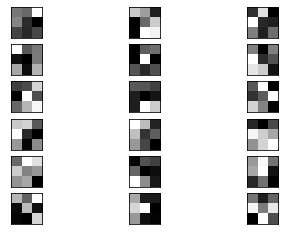

In [56]:

# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [58]:

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

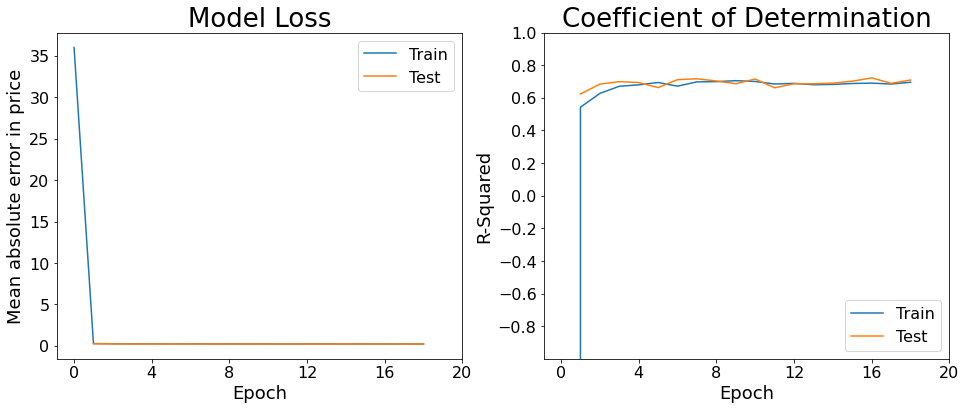

In [59]:
# create figure
fig= plt.figure(figsize=(16,6))
#plt.suptitle('Artifical Neural Network on Home Features')
titlesize=26
fontsize=18
# loss plot on left
plt.subplot(1,2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
         
plt.title('Model Loss', fontsize=titlesize)
plt.ylabel('Mean absolute error in price', fontsize=fontsize)
plt.xlabel('Epoch', fontsize=fontsize)
plt.xticks([0, 4, 8, 12, 16,20 ])
plt.legend(['Train', 'Test'], loc='upper right')

# coeff plot on right
plt.subplot(1,2, 2)
plt.plot(history.history['coeff_determination'])
plt.plot(history.history['val_coeff_determination'])

plt.title('Coefficient of Determination', fontsize= titlesize)
plt.ylabel('R-Squared',  fontsize=fontsize)
plt.ylim(-1,1)
plt.yticks([1, .8, .6, .4, .2, 0, -0.2, -0.4, -0.6, -0.8 ])
plt.xticks([0, 4, 8, 12, 16,20 ])
plt.xlabel('Epoch', fontsize=fontsize)
plt.legend(['Train', 'Test'], loc='lower right')

plt.show()

Conclusion: Using the color images did not greatly improve performance.